In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/IdanReed/AtariDeepLearning.git
%cd AtariDeepLearning
%load_ext autoreload
%autoreload 2

# Pull data from Vaibhav's google drive
!pip install gdown
!gdown "https://drive.google.com/uc?id=1ExuGJteCja1DQXG_zUAfH6xe4EIFfQfr"
!unzip -q dataset.zip -d /tmp/dataset


Cloning into 'AtariDeepLearning'...
remote: Enumerating objects: 453, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 453 (delta 97), reused 240 (delta 86), pack-reused 185 (from 1)
Receiving objects: 100% (453/453), 156.08 MiB | 42.11 MiB/s, done.
Resolving deltas: 100% (193/193), done.
/workspace/AtariDeepLearning
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gdown]
Downloading...
From (original): https://drive.google.com/uc?id=1ExuGJteCja1DQXG_zUAfH6xe4EIFfQfr
From (redirected): https://drive.google.com/uc?id=1ExuGJteCja1DQXG_zUAfH6xe4EIFfQfr&confirm=t&uuid=ed6c39e4-ea43-439d-a6e3-206db196f384
To: /workspace/AtariDeepLearning/dataset.zip
100%|███████████████████████████████████████| 3.92G/3.92G [00:27<00:00, 145MB/s]


In [3]:
%cd /content/AtariDeepLearning
!git pull

/content/AtariDeepLearning
Already up to date.


In [3]:
!pip install optuna

from utils import seed_random_generators
seed_random_generators()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.9/609.9 kB 32.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [optuna]2m5/6 [optuna]]my]


In [4]:
from pathlib import Path
OUTPUT_DIR = Path("output").joinpath("baseline")

from utils import safe_clear_output_dir
safe_clear_output_dir(OUTPUT_DIR)

# Automatically Sync with Github Code

In [6]:
%cd /content/AtariDeepLearning
!git pull

/content/AtariDeepLearning
Already up to date.


# Load Data

In [5]:
from npz_loader import load_episodes

dataset_root = Path("/tmp/dataset/dataset")
holdout_game_dirs = [
    dataset_root.joinpath("BeamRiderNoFrameskip-v4", "BeamRiderNoFrameskip-v4"),
    dataset_root.joinpath("BreakoutNoFrameskip-v4", "BreakoutNoFrameskip-v4")
]

main_game_dirs = [
    dataset_root.joinpath("EnduroNoFrameskip-v4", "EnduroNoFrameskip-v4"),
    dataset_root.joinpath("MsPacmanNoFrameskip-v4", "MsPacmanNoFrameskip-v4"),
    dataset_root.joinpath("PongNoFrameskip-v4", "PongNoFrameskip-v4"),
    dataset_root.joinpath("QbertNoFrameskip-v4", "QbertNoFrameskip-v4"),
    dataset_root.joinpath("SeaquestNoFrameskip-v4", "SeaquestNoFrameskip-v4"),
    dataset_root.joinpath("SpaceInvadersNoFrameskip-v4", "SpaceInvadersNoFrameskip-v4")
]
episodes = load_episodes(main_game_dirs, holdout_game_dirs, True)

Loaded 1880 episodes


In [17]:
from utils import sample_list
sampled_episodes = sample_list(episodes, fraction=1)

Sampled 1880 items (100.0% of 1880 total)


In [18]:
from epsiode_dataloader import make_train_val_dataloaders

main_bundle, holdout_bundle, bins = make_train_val_dataloaders(
    episodes=sampled_episodes,
    holdout_game_dirs=holdout_game_dirs,
    train_frac=0.8,
    timestep_window_size=4,
)

# Dataloader - Main Games

Saved plot to output/baseline/dataloader_main_train.png


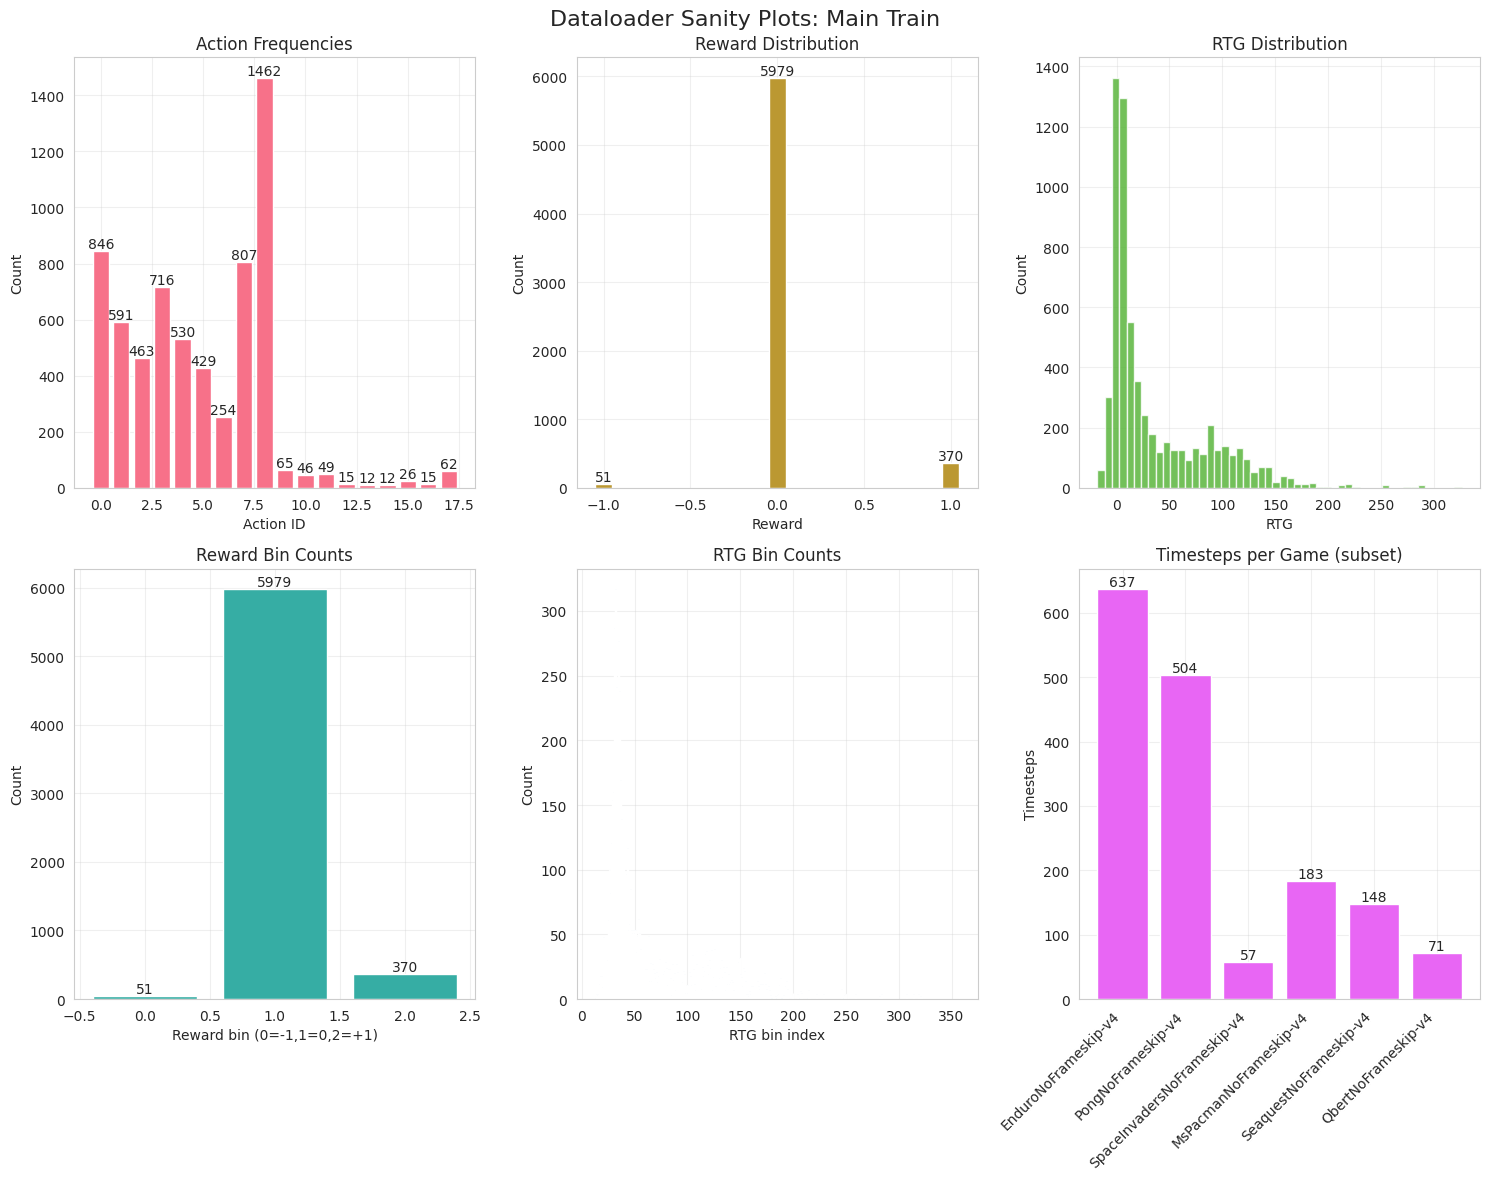

Dataloader size: 40488
Saved plot to output/baseline/dataloader_main_validate.png


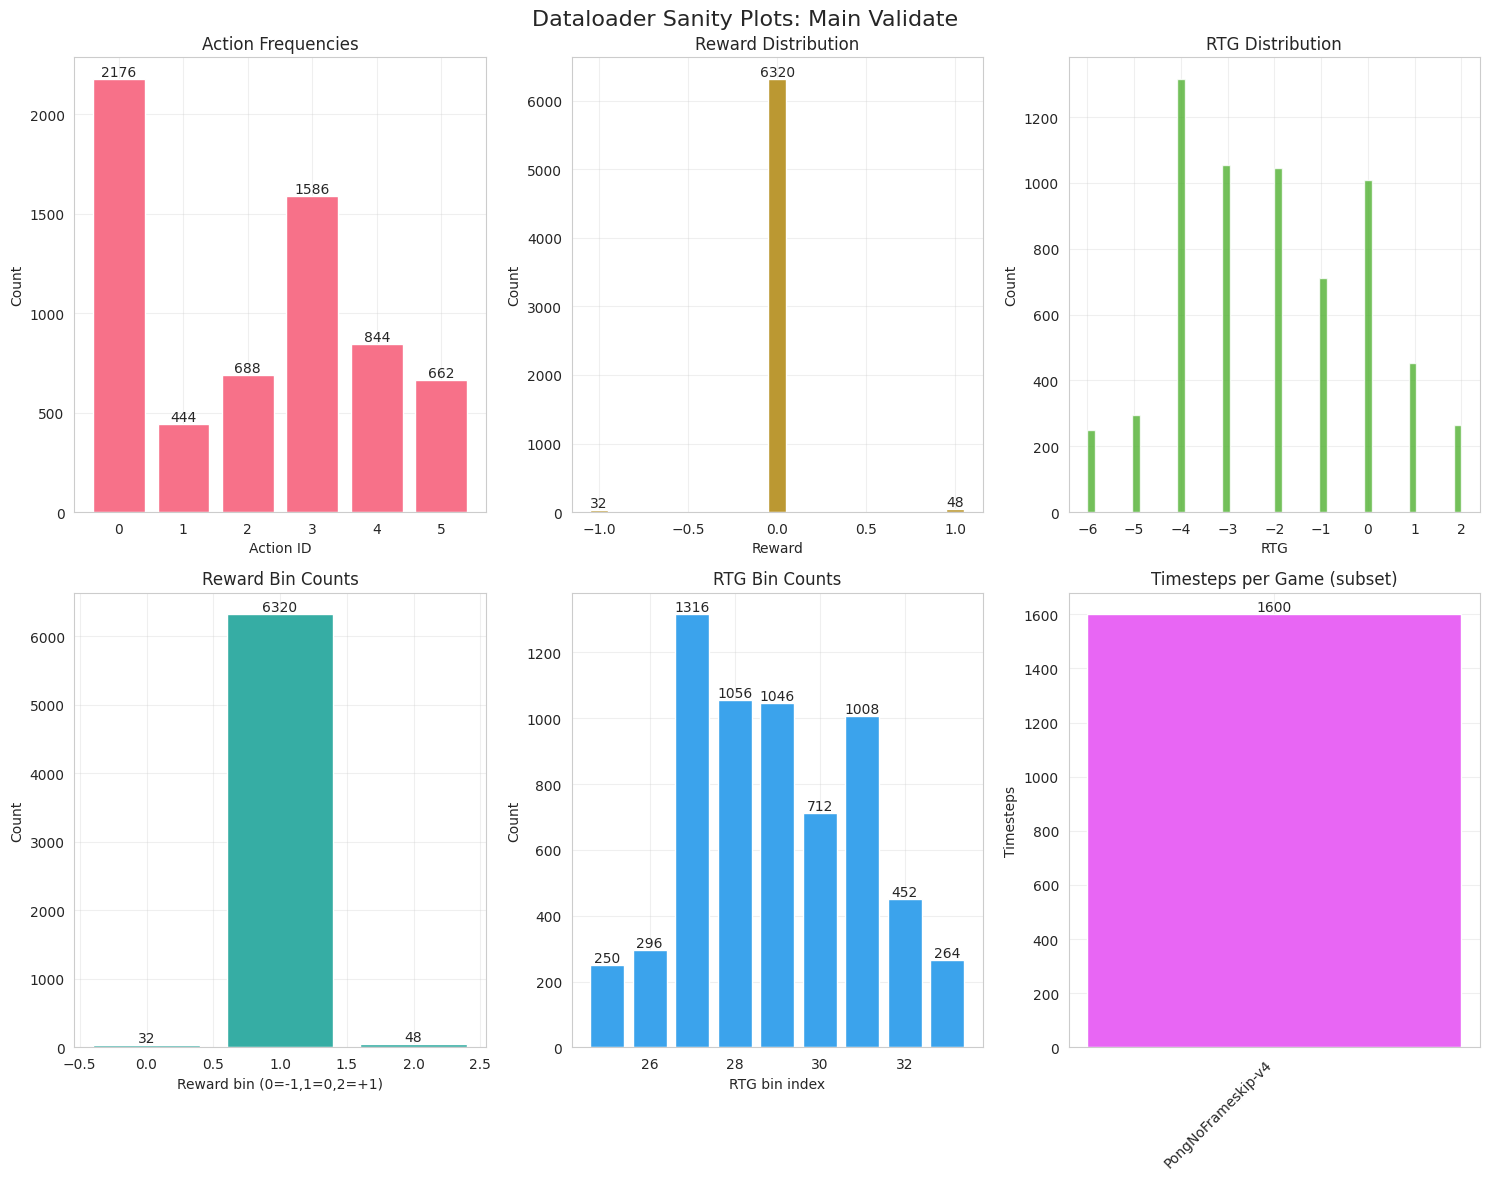

Dataloader size: 10833


In [19]:
!pip install matplotlib
!pip install seaborn

from dataloader_stats import inspect_dataloader

_ = inspect_dataloader(main_bundle.train_loader, "Main Train", output_dir=OUTPUT_DIR)
_ = inspect_dataloader(main_bundle.val_loader, "Main Validate", output_dir=OUTPUT_DIR)

# Dataloader - Holdout Games

Saved plot to output/baseline/dataloader_holdout_train.png


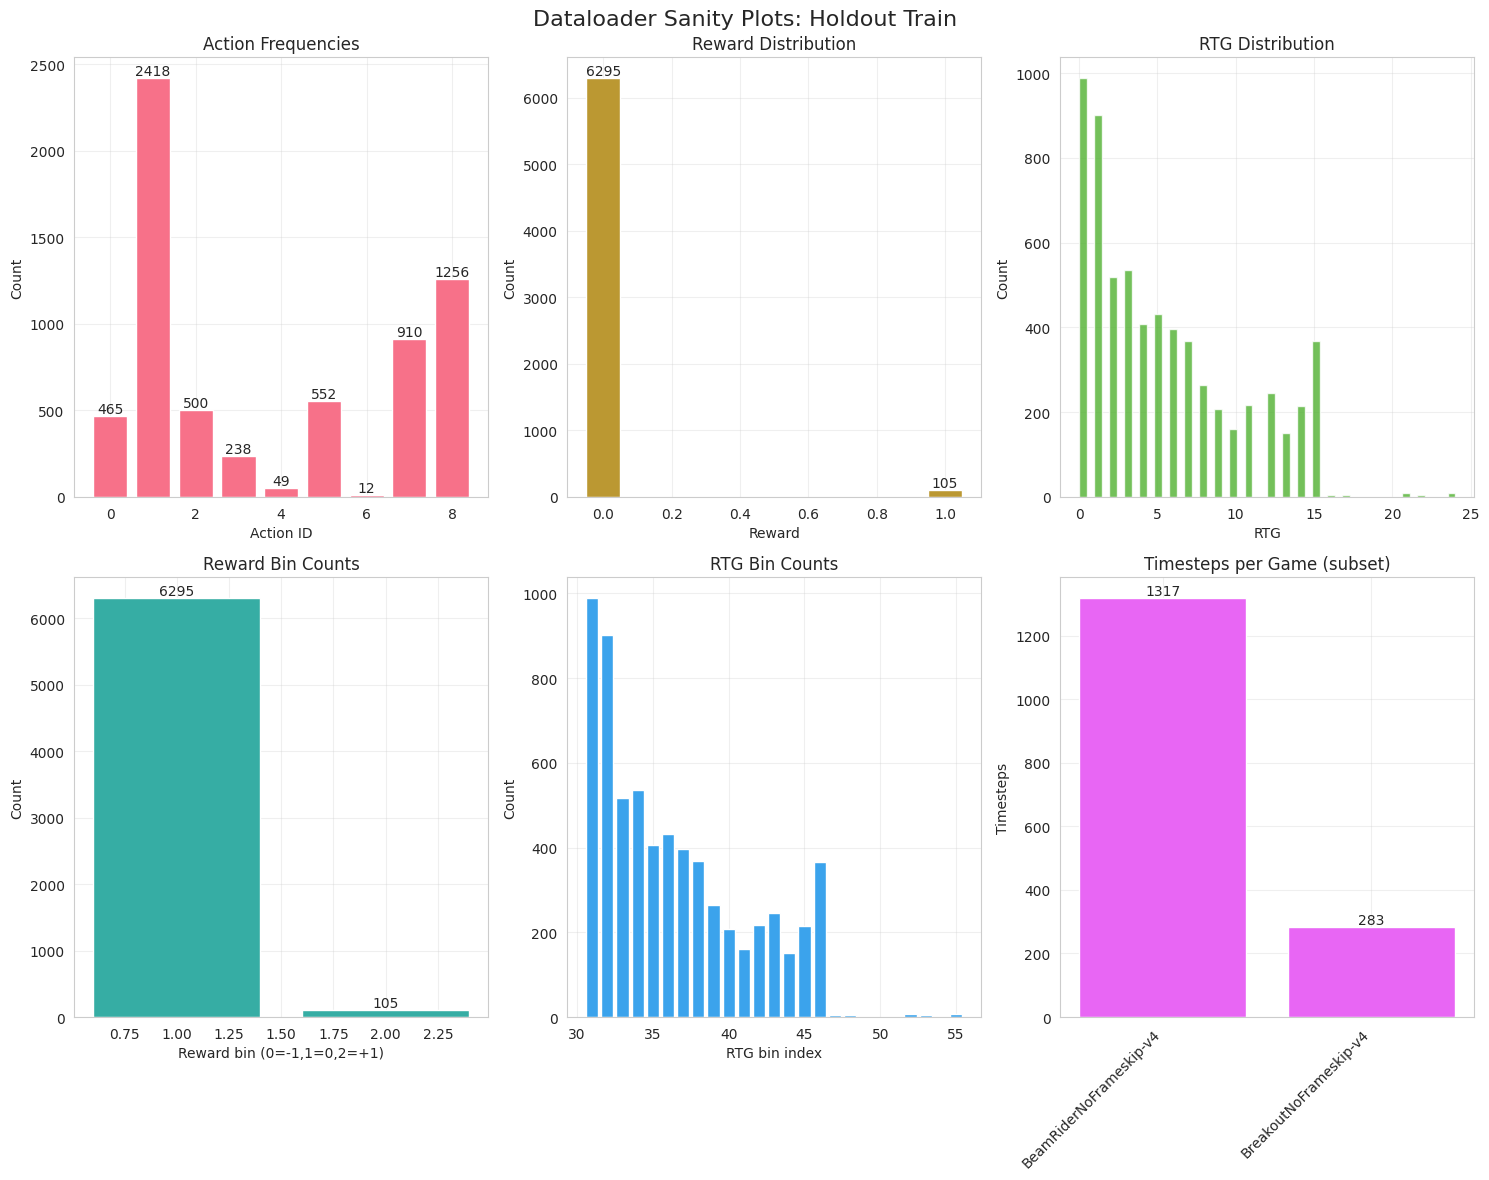

Dataloader size: 4383
Saved plot to output/baseline/dataloader_holdout_validate.png


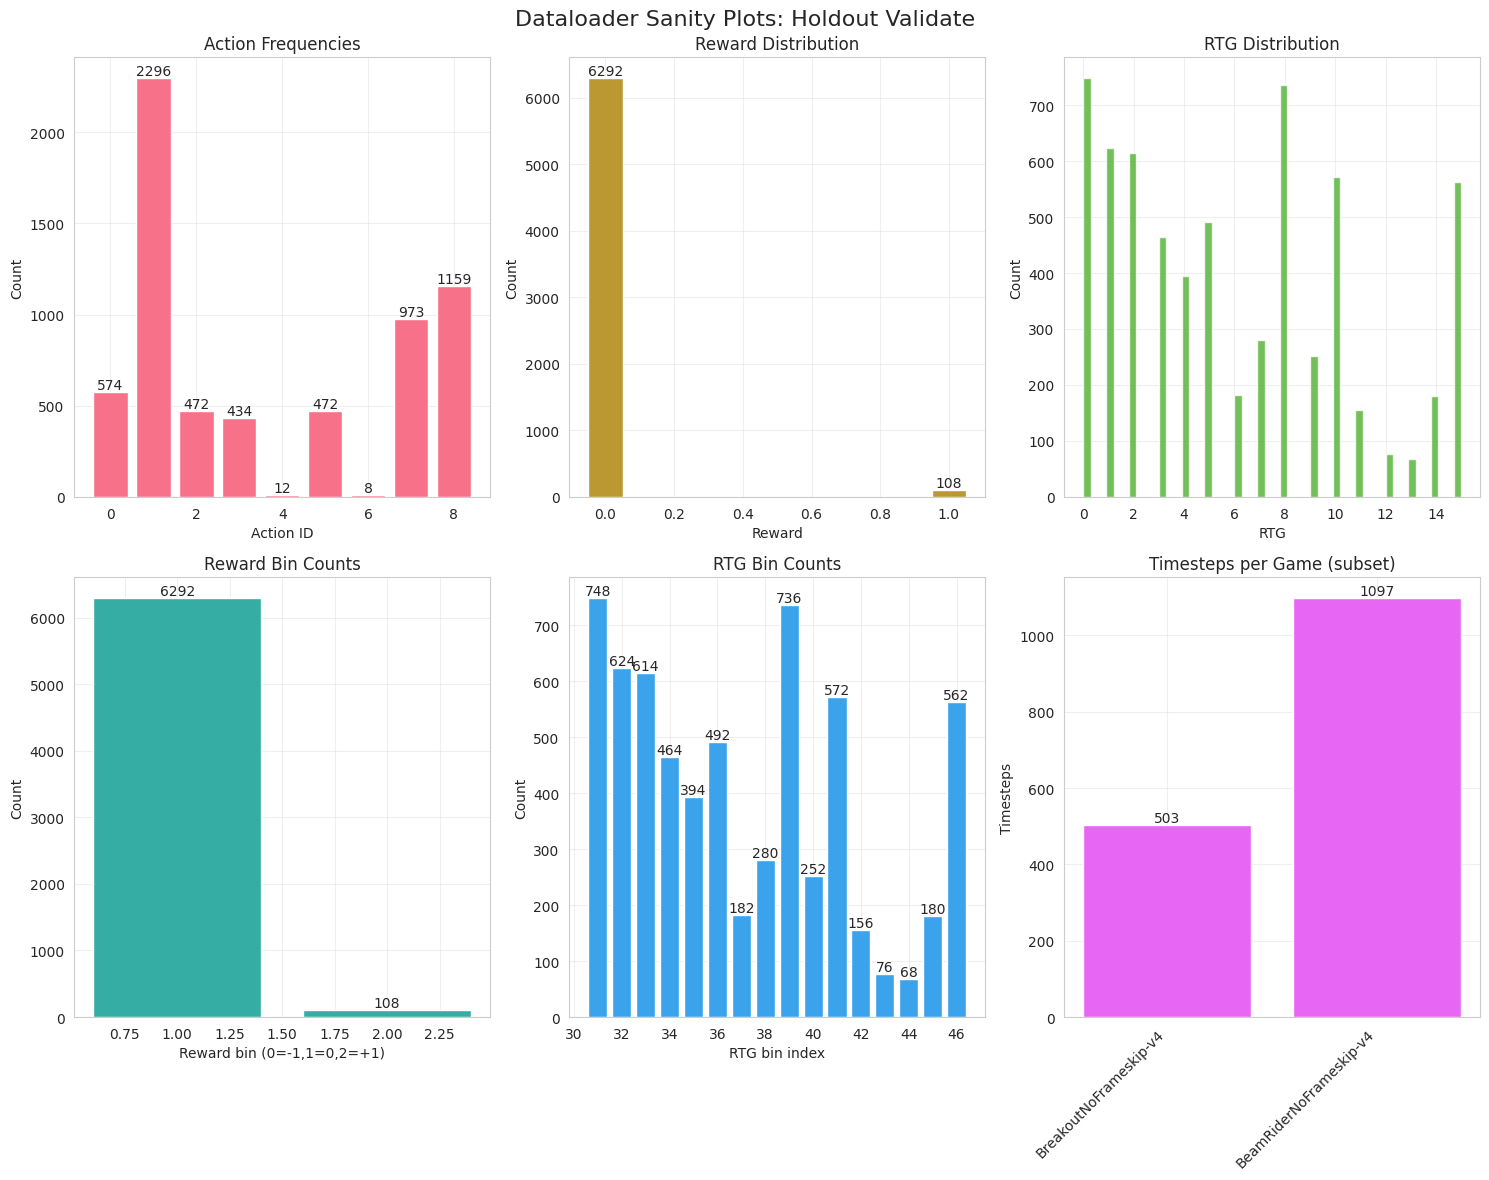

Dataloader size: 981


In [20]:
_ = inspect_dataloader(holdout_bundle.train_loader, "Holdout Train", output_dir=OUTPUT_DIR)
_ = inspect_dataloader(holdout_bundle.val_loader, "Holdout Validate", output_dir=OUTPUT_DIR)

# Train - Main Games

In [13]:
!pip install scikit-learn
from optuna_tuning import run_optuna

#optuna with 10% data
study = run_optuna(main_bundle.train_loader, main_bundle.val_loader, bins,
 lr_range = (1e-5, 1e-2),
  emb_size_choices = [64, 128, 256, 512],
                   n_layers_range = (2, 6),
                   n_heads_range=(1,4),
                   num_epochs_range=(1,2))
best_lr = study.best_params['learning_rate']
best_emb_size = study.best_params['embedding_size']
best_n_layers = study.best_params['num_layers']
best_n_heads = study.best_params['num_heads']
best_num_epochs = study.best_params['num_epochs']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 119.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 152.2 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


[I 2025-12-10 14:37:38,884] A new study created in memory with name: no-name-fb619d66-464f-4bd6-9fa0-72e5bbffc5af
[I 2025-12-10 14:37:38,886] Trial 0 pruned. 
[I 2025-12-10 14:37:38,887] Trial 1 pruned. 


Trial params: {'lr': 0.0009346076744462014, 'emb_size': 64, 'n_layers': 5, 'n_heads': 3, 'num_epochs': 2}
Trial params: {'lr': 3.1811792570762774e-05, 'emb_size': 512, 'n_layers': 3, 'n_heads': 3, 'num_epochs': 2}
Trial params: {'lr': 0.0007750438878390556, 'emb_size': 128, 'n_layers': 3, 'n_heads': 1, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 3928/3928 [01:25<00:00, 46.13it/s] 
[I 2025-12-10 14:41:30,854] Trial 2 finished with value: 2.4479048252105713 and parameters: {'lr': 0.0007750438878390556, 'emb_size': 128, 'n_layers': 3, 'n_heads': 1, 'num_epochs': 2}. Best is trial 2 with value: 2.4479048252105713.


Trial params: {'lr': 0.008437850681304513, 'emb_size': 64, 'n_layers': 4, 'n_heads': 2, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 3928/3928 [01:24<00:00, 46.27it/s] 
[I 2025-12-10 14:45:18,073] Trial 3 finished with value: 2.2049801349639893 and parameters: {'lr': 0.008437850681304513, 'emb_size': 64, 'n_layers': 4, 'n_heads': 2, 'num_epochs': 2}. Best is trial 3 with value: 2.2049801349639893.


Trial params: {'lr': 0.00200534995790141, 'emb_size': 128, 'n_layers': 5, 'n_heads': 4, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 3928/3928 [01:26<00:00, 45.40it/s] 
[I 2025-12-10 14:49:06,408] Trial 4 finished with value: 1.49867844581604 and parameters: {'lr': 0.00200534995790141, 'emb_size': 128, 'n_layers': 5, 'n_heads': 4, 'num_epochs': 2}. Best is trial 4 with value: 1.49867844581604.


Trial params: {'lr': 8.347639481426097e-05, 'emb_size': 512, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 3928/3928 [01:23<00:00, 46.81it/s] 
[I 2025-12-10 14:52:51,915] Trial 5 finished with value: 1.1526132822036743 and parameters: {'lr': 8.347639481426097e-05, 'emb_size': 512, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 2}. Best is trial 5 with value: 1.1526132822036743.


Trial params: {'lr': 0.004348895007681191, 'emb_size': 256, 'n_layers': 6, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:24<00:00, 46.76it/s]
[I 2025-12-10 14:54:46,057] Trial 6 finished with value: 1.6843587160110474 and parameters: {'lr': 0.004348895007681191, 'emb_size': 256, 'n_layers': 6, 'n_heads': 4, 'num_epochs': 1}. Best is trial 5 with value: 1.1526132822036743.


Trial params: {'lr': 1.9738027749052035e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:28<00:00, 44.35it/s]
[I 2025-12-10 14:56:44,102] Trial 7 finished with value: 1.0167734622955322 and parameters: {'lr': 1.9738027749052035e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}. Best is trial 7 with value: 1.0167734622955322.


Trial params: {'lr': 0.00023135160894857567, 'emb_size': 256, 'n_layers': 2, 'n_heads': 1, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 3928/3928 [01:27<00:00, 44.75it/s] 
[I 2025-12-10 15:00:41,133] Trial 8 finished with value: 1.154471755027771 and parameters: {'lr': 0.00023135160894857567, 'emb_size': 256, 'n_layers': 2, 'n_heads': 1, 'num_epochs': 2}. Best is trial 7 with value: 1.0167734622955322.


Trial params: {'lr': 1.1770899198279967e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:28<00:00, 44.57it/s]
[I 2025-12-10 15:02:39,253] Trial 9 finished with value: 0.9482901096343994 and parameters: {'lr': 1.1770899198279967e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}. Best is trial 9 with value: 0.9482901096343994.
[I 2025-12-10 15:02:39,259] Trial 10 pruned. 


Trial params: {'lr': 1.041595248766253e-05, 'emb_size': 512, 'n_layers': 6, 'n_heads': 3, 'num_epochs': 1}
Trial params: {'lr': 1.1278758610397637e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:25<00:00, 45.99it/s]
[I 2025-12-10 15:04:34,649] Trial 11 finished with value: 1.1060352325439453 and parameters: {'lr': 1.1278758610397637e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}. Best is trial 9 with value: 0.9482901096343994.


Trial params: {'lr': 5.308458726627875e-05, 'emb_size': 512, 'n_layers': 3, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:28<00:00, 44.63it/s]
[I 2025-12-10 15:06:31,657] Trial 12 finished with value: 1.1635633707046509 and parameters: {'lr': 5.308458726627875e-05, 'emb_size': 512, 'n_layers': 3, 'n_heads': 4, 'num_epochs': 1}. Best is trial 9 with value: 0.9482901096343994.


Trial params: {'lr': 2.3588238100739336e-05, 'emb_size': 512, 'n_layers': 5, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:25<00:00, 46.21it/s]
[I 2025-12-10 15:08:25,691] Trial 13 finished with value: 1.1303529739379883 and parameters: {'lr': 2.3588238100739336e-05, 'emb_size': 512, 'n_layers': 5, 'n_heads': 4, 'num_epochs': 1}. Best is trial 9 with value: 0.9482901096343994.
[I 2025-12-10 15:08:25,697] Trial 14 pruned. 


Trial params: {'lr': 0.00016950035501681673, 'emb_size': 512, 'n_layers': 4, 'n_heads': 3, 'num_epochs': 1}
Trial params: {'lr': 8.01457891970871e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:27<00:00, 44.74it/s]
[I 2025-12-10 15:10:22,782] Trial 15 finished with value: 1.3009145259857178 and parameters: {'lr': 8.01457891970871e-05, 'emb_size': 512, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 1}. Best is trial 9 with value: 0.9482901096343994.


Trial params: {'lr': 2.268215909257315e-05, 'emb_size': 256, 'n_layers': 3, 'n_heads': 2, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:23<00:00, 46.91it/s]
[I 2025-12-10 15:12:15,394] Trial 16 finished with value: 1.1182687282562256 and parameters: {'lr': 2.268215909257315e-05, 'emb_size': 256, 'n_layers': 3, 'n_heads': 2, 'num_epochs': 1}. Best is trial 9 with value: 0.9482901096343994.
[I 2025-12-10 15:12:15,400] Trial 17 pruned. 


Trial params: {'lr': 1.0576345455143329e-05, 'emb_size': 128, 'n_layers': 5, 'n_heads': 3, 'num_epochs': 1}
Trial params: {'lr': 0.0004586591905068345, 'emb_size': 64, 'n_layers': 3, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 3928/3928 [01:25<00:00, 45.85it/s]
[I 2025-12-10 15:14:10,147] Trial 18 finished with value: 1.2493579387664795 and parameters: {'lr': 0.0004586591905068345, 'emb_size': 64, 'n_layers': 3, 'n_heads': 4, 'num_epochs': 1}. Best is trial 9 with value: 0.9482901096343994.
[I 2025-12-10 15:14:10,153] Trial 19 pruned. 


Trial params: {'lr': 0.0001088291620812333, 'emb_size': 512, 'n_layers': 4, 'n_heads': 3, 'num_epochs': 1}


TypeError: 'Study' object is not subscriptable

In [15]:
best_lr = study.best_params['lr']
best_emb_size = study.best_params['emb_size']
best_n_layers = study.best_params['n_layers']
best_n_heads = study.best_params['n_heads']
best_num_epochs = study.best_params['num_epochs']

In [21]:
from mgdt_model_trainer import Encoder, train_mgdt

#Training with 100% data
model, main_train_stats, main_val_stats = train_mgdt(
    bins=bins,
    dataloader_train=main_bundle.train_loader,
    dataloader_val=main_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=best_num_epochs,
    lr=best_lr,
    emb_size=best_emb_size,
    n_layers=best_n_layers,
    n_heads=best_n_heads
)

Epoch 1/1: 100%|██████████| 40488/40488 [19:34<00:00, 34.47it/s][A
                                                                 

Saved plot to output/baseline/model_main_losses_per_head.png


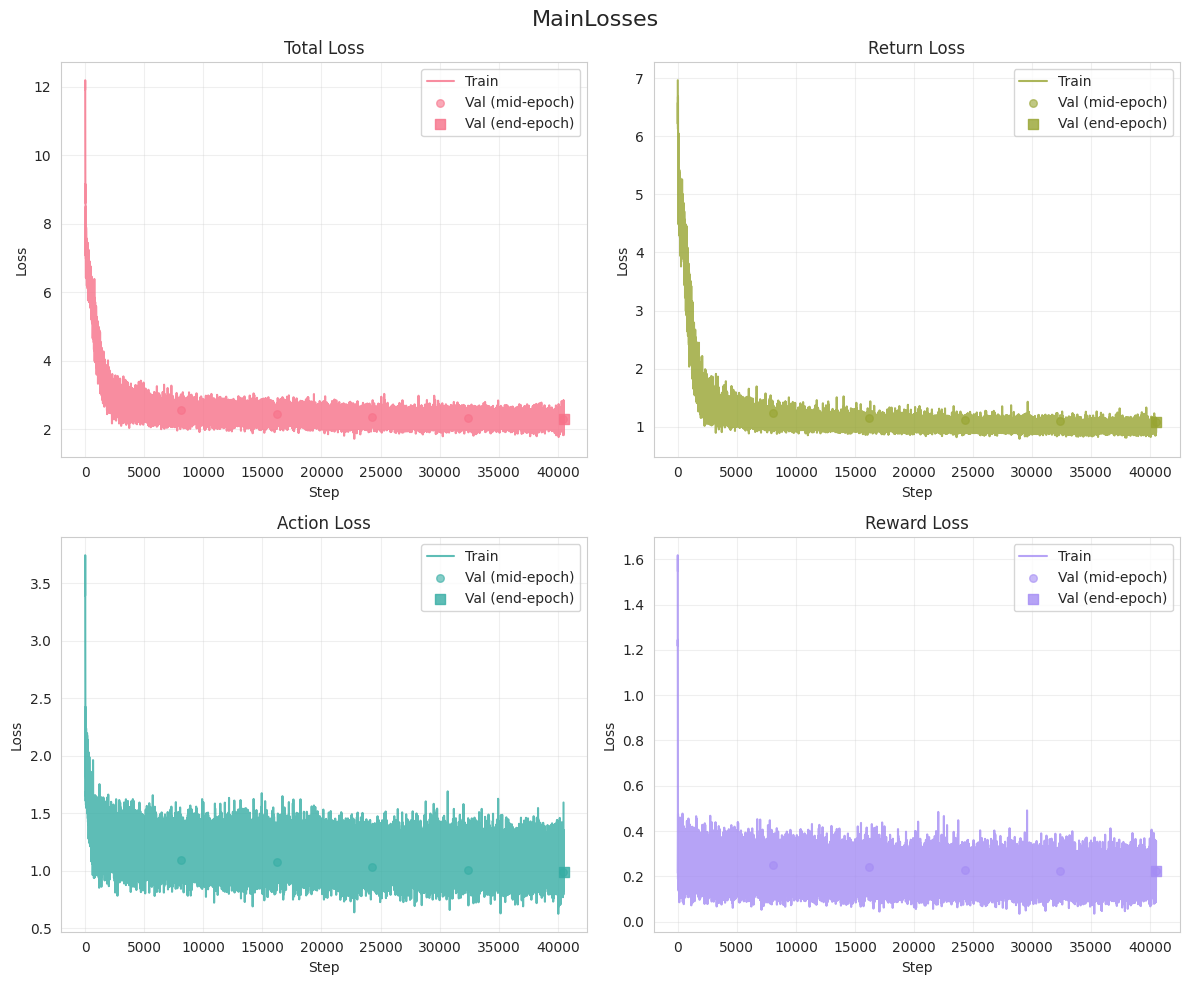

Saved plot to output/baseline/model_main_losses_combined.png


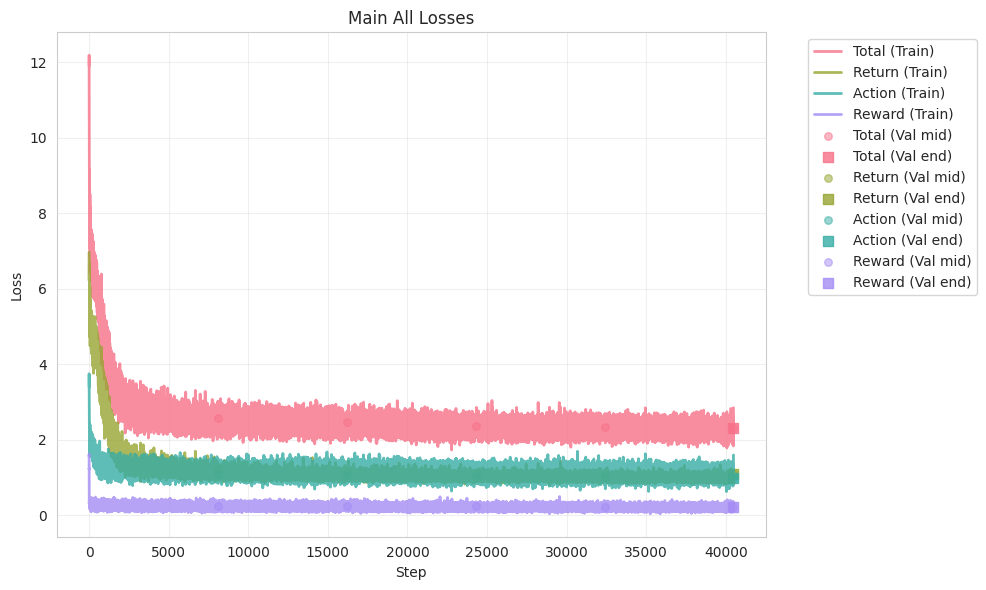

Saved plot to output/baseline/model_main_losses_ema_per_head.png


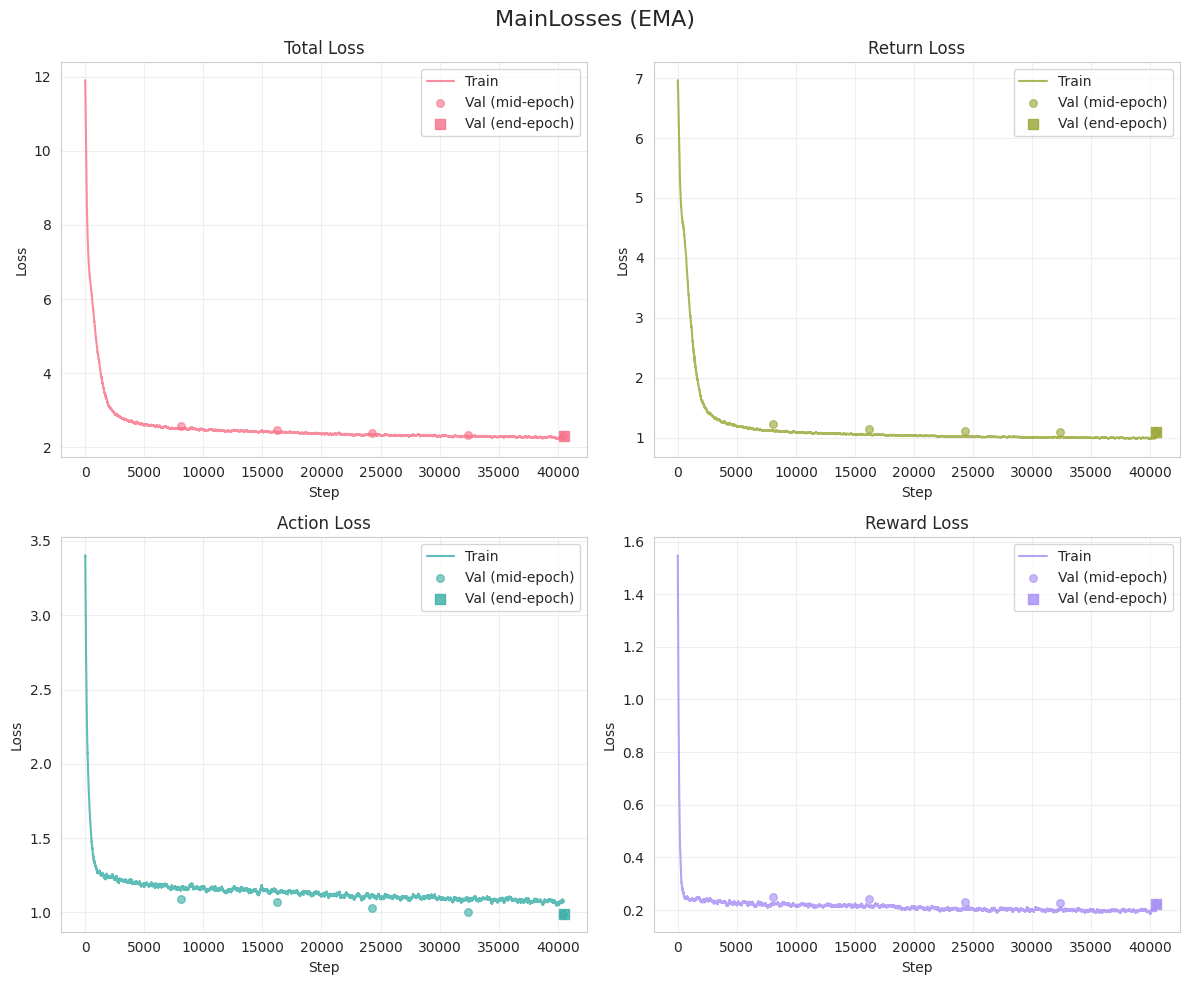

Saved plot to output/baseline/model_main_losses_ema_combined.png


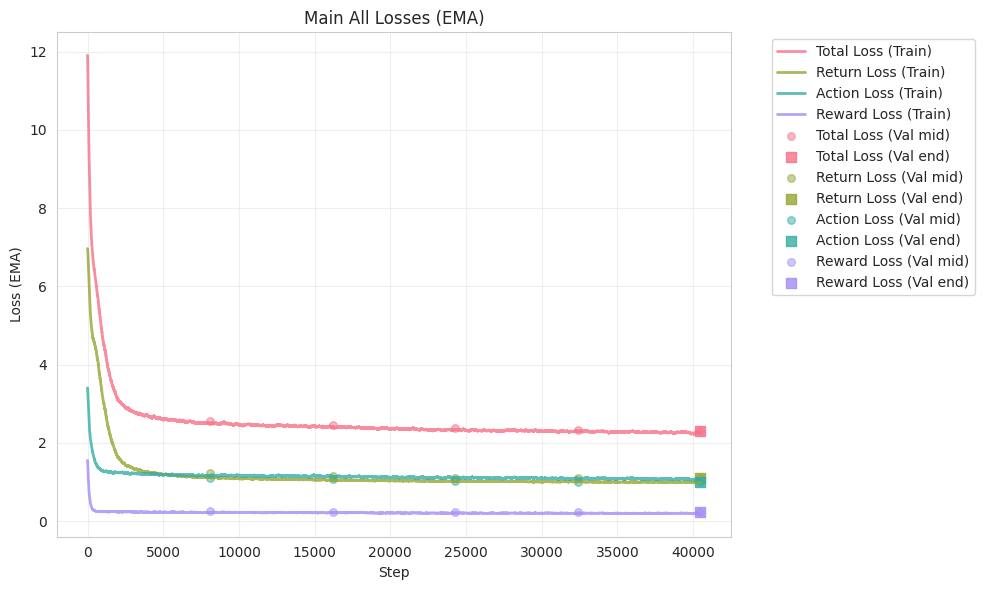

In [22]:
from mgdt_model_stats import plot_losses
plot_losses(main_train_stats, main_val_stats, output_dir=OUTPUT_DIR, title_prefix="Main")

# Test Freeze

In [23]:
from mgdt_model import Freezeable
model.freeze(components=[Freezeable.Transformer])

1

# Train - Holdout Games

In [24]:
from mgdt_model_trainer import Encoder, train_mgdt

model, holdout_train_stats, holdout_val_stats = train_mgdt(
    model=model,
    bins=bins,
    dataloader_train=holdout_bundle.train_loader,
    dataloader_val=holdout_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=1,
)

Finetune 1/1: 100%|██████████| 4383/4383 [02:03<00:00, 35.49it/s]
                                                             

Saved plot to output/baseline/model_holdout_losses_per_head.png


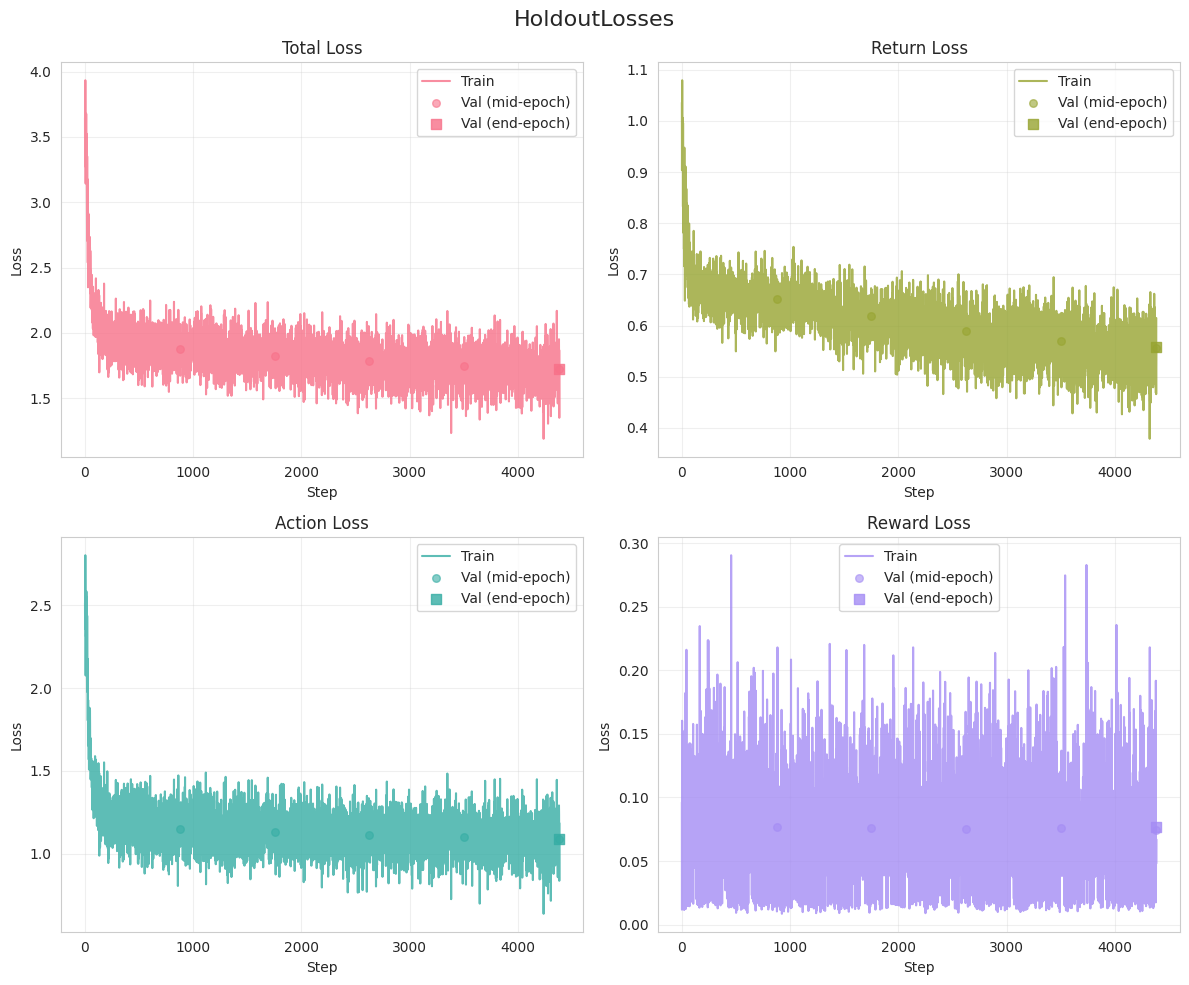

Saved plot to output/baseline/model_holdout_losses_combined.png


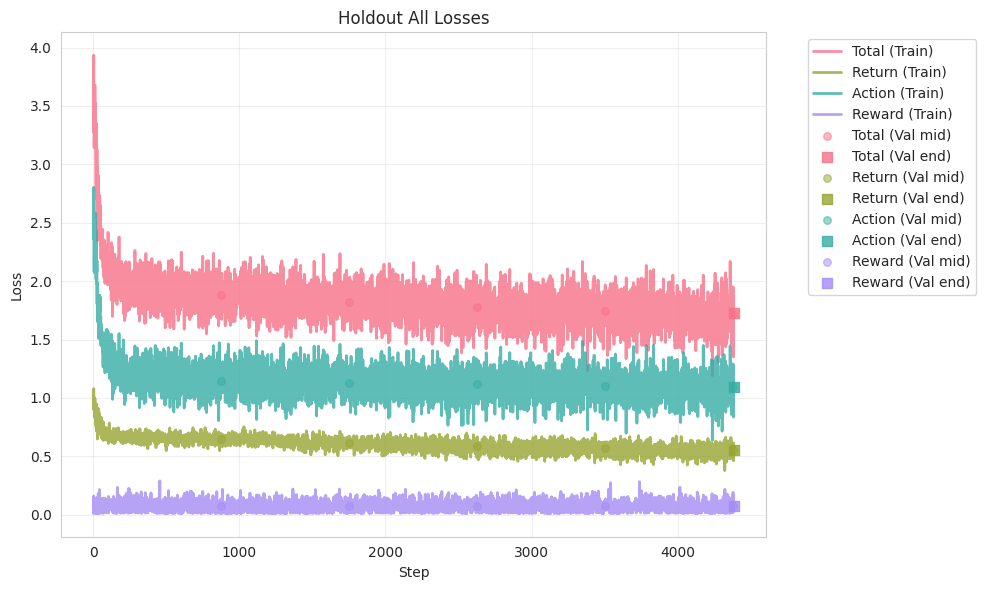

Saved plot to output/baseline/model_holdout_losses_ema_per_head.png


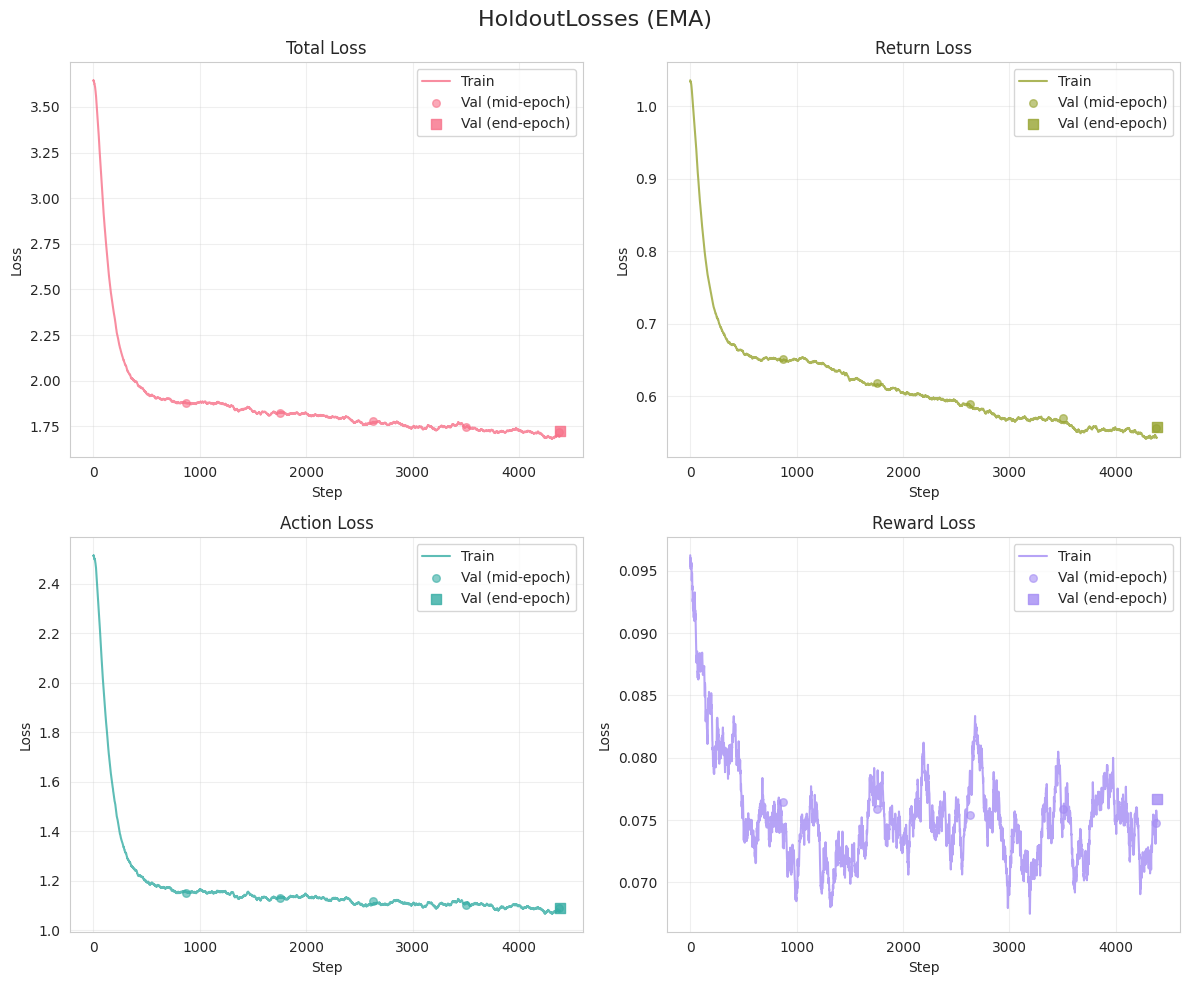

Saved plot to output/baseline/model_holdout_losses_ema_combined.png


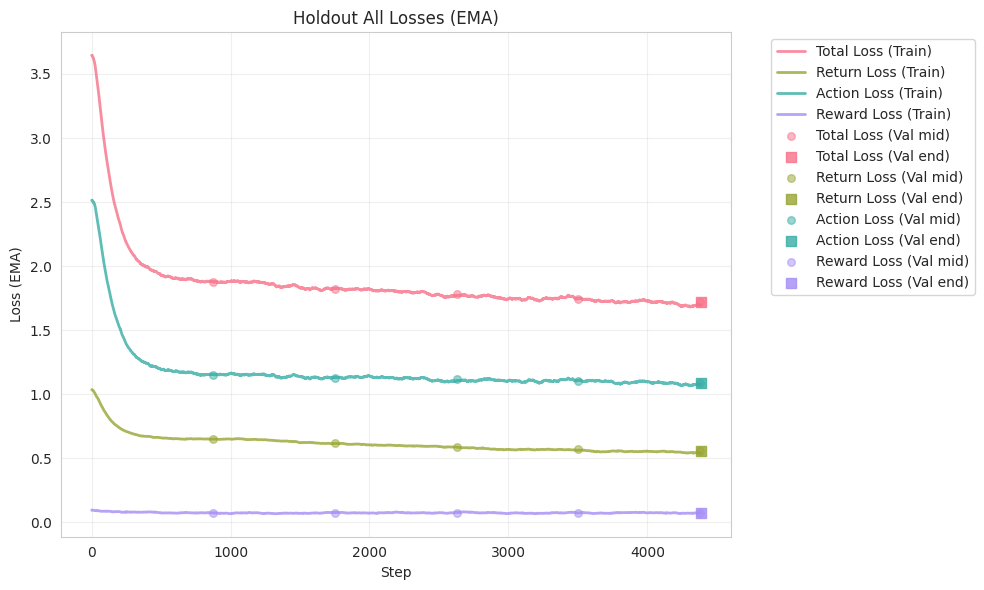

In [25]:
from mgdt_model_stats import plot_losses
plot_losses(holdout_train_stats, holdout_val_stats, output_dir=OUTPUT_DIR, title_prefix="Holdout")

# Comparison

Saved plot to output/baseline/comparison_baseline_main_vs_holdout.png


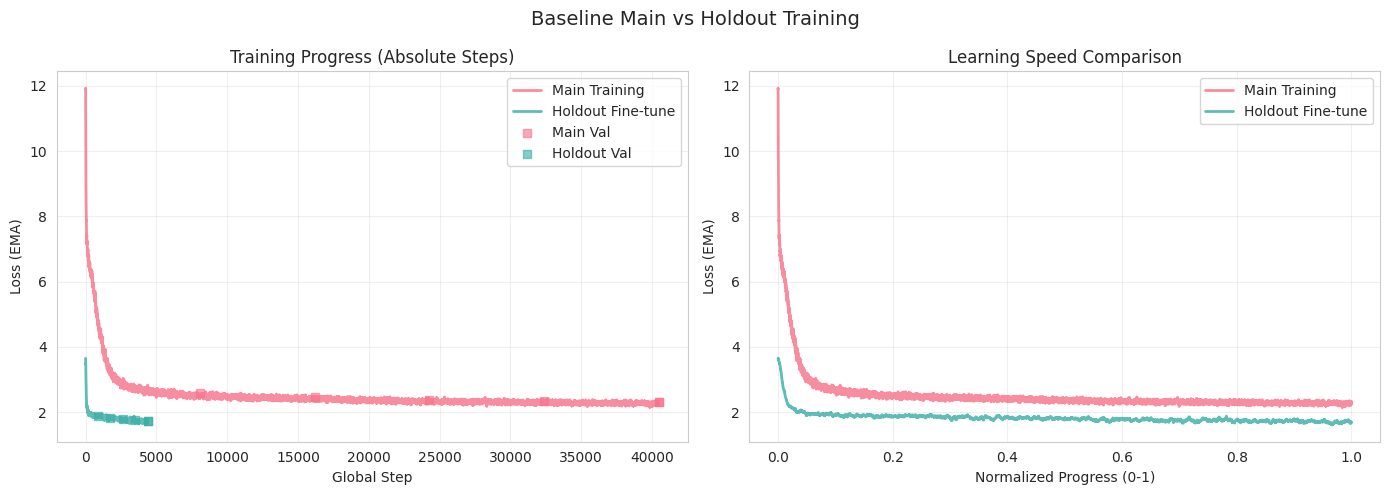

Saved plot to output/baseline/comparison_baseline_per_head_loss.png


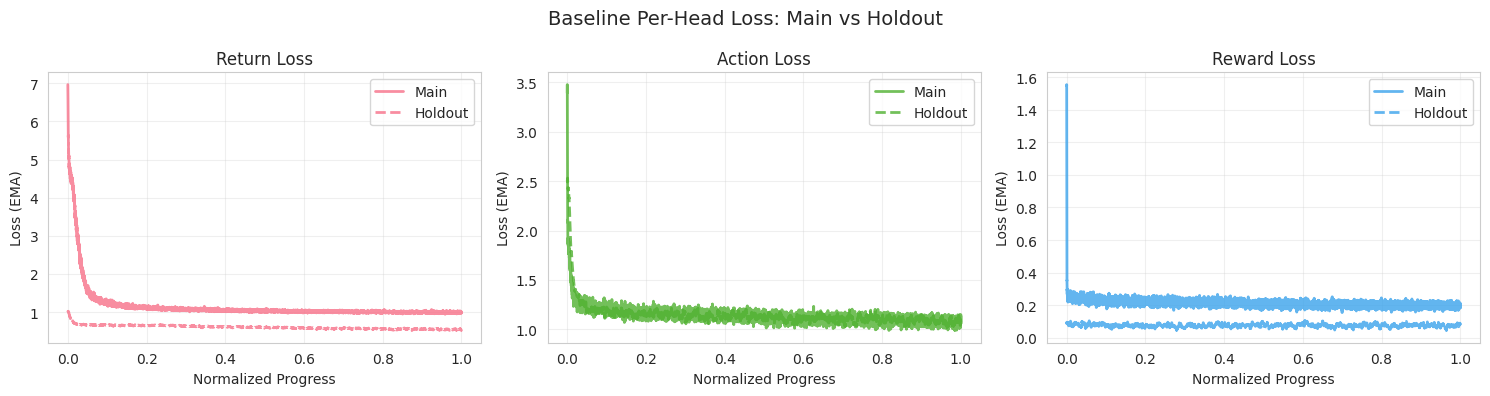

Saved plot to output/baseline/comparison_baseline_accuracy.png


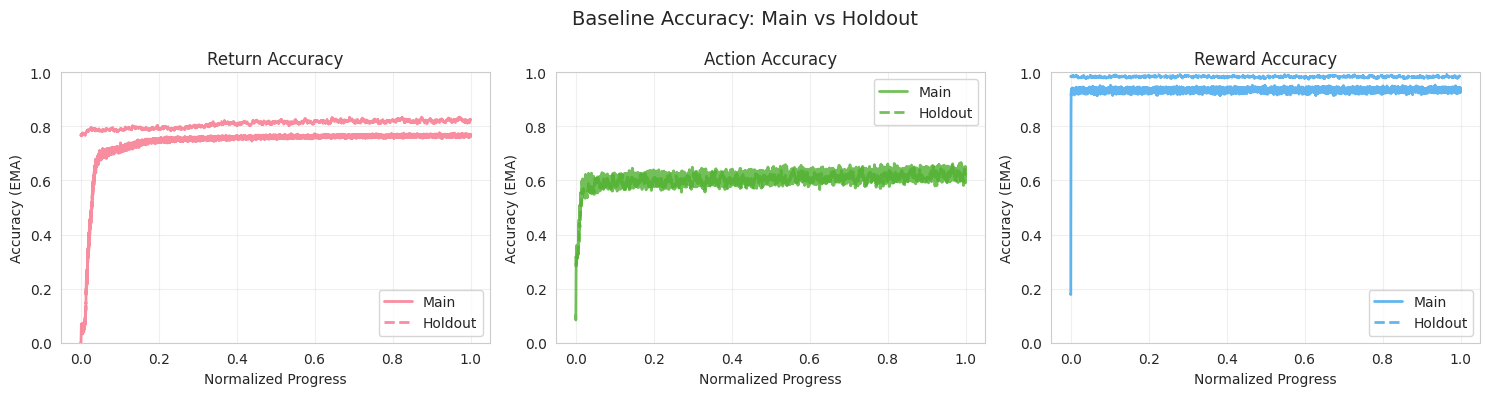


HOLDOUT ADAPTATION SUMMARY
Main training steps: 40488
Holdout fine-tune steps: 4383

Main training - Final loss (EMA): 2.3310
Holdout fine-tune - Initial loss (EMA): 3.6458
Holdout fine-tune - Final loss (EMA): 1.6841
Holdout loss reduction: 1.9617

Holdout reached main's final loss at step 68 (1.6% of fine-tuning)


In [26]:
from mgdt_model_stats import plot_holdout_comparison

plot_holdout_comparison(main_train_stats, main_val_stats, holdout_train_stats, holdout_val_stats, output_dir=OUTPUT_DIR, title_prefix="Baseline")

# Model Info and Save

In [ ]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6:.0f}M")

In [ ]:
from utils import save_checkpoint

save_checkpoint(model, main_train_stats, main_val_stats, output_dir=OUTPUT_DIR)

In [ ]:
!zip -r output.zip output
from google.colab import files
files.download("output.zip")